In [1]:
# %pip install opencv-python
from utilities import ShowImage
from imgAlignment import align_board
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def filter_hough_lines(lines, min_length=300, angle_threshold=10):
    verticals = []
    horizontals = []
    for x1, y1, x2, y2 in lines[:, 0]:
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        if length < min_length:
            continue
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        if abs(angle) < angle_threshold or abs(angle - 180) < angle_threshold:
            horizontals.append((x1, y1, x2, y2))
        elif abs(angle - 90) < angle_threshold or abs(angle + 90) < angle_threshold:
            verticals.append((x1, y1, x2, y2))
    return verticals, horizontals


In [3]:
def detect_board_and_warp(image, output_size=(800, 800)):
    # Load and resize image (optional)
    img = (image)
    # img = cv2.resize(img, (1000, 1000))  # scale for consistency
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #plot grayscaled image
    plt.imshow(gray, cmap='gray')
    plt.axis('off')
    plt.show()
    
    edges = cv2.Canny(gray, 50, 150, apertureSize=3) # the parameters are: 
                                                     # Lowthreshold(which is the lower bound for the hysteresis thresholding), 
                                                     # Highthreshold(which is the upper bound for the hysteresis thresholding), 
                                                     # and apertureSize(which is the size of the Sobel kernel used to compute the gradient).
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=100, minLineLength=70, maxLineGap=15)
    
    debug_lines = img.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(debug_lines, (x1, y1), (x2, y2), (255, 0, 0), 5)
            
    # Approximate outer rectangle from Hough lines (very naive)
    # We assume that the outermost lines (bounding the board) are the longest horizontal/vertical
    verticals = []
    horizontals = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(x1 - x2) < 20:  # vertical line
            verticals.append(line[0])
        elif abs(y1 - y2) < 20:  # horizontal line
            horizontals.append(line[0])
            
    top = min(horizontals, key=lambda l: l[1])
    bottom = max(horizontals, key=lambda l: l[1])
    left = min(verticals, key=lambda l: l[0])
    right = max(verticals, key=lambda l: l[0])
    
    src_pts = np.array([
        [left[0], top[1]],
        [right[2], top[1]],
        [right[2], bottom[3]],
        [left[0], bottom[3]]
    ], dtype='float32')

    dst_pts = np.array([
        [0, 0],
        [output_size[0] - 1, 0],
        [output_size[0] - 1, output_size[1] - 1],
        [0, output_size[1] - 1]
    ], dtype='float32')

    # Perspective warp
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, matrix, output_size)

    return img, debug_lines, warped

In [ ]:
def split_board_into_cells(warped_img, grid_X_size=16, padding=0):
    cell_height = warped_img.shape[0] // grid_X_size
    cell_width = warped_img.shape[1] // grid_X_size
    
    cells = {}
    for i in range(grid_X_size):
        for j in range(grid_X_size):
            x1 = j * cell_width
            y1 = i * cell_height
            x2 = (j + 1) * cell_width
            y2 = (i + 1) * cell_height
            
            pad_x = int(padding * cell_width)
            pad_y = int(padding * cell_height)
            
            x1 = max(0, x1 - pad_x)
            y1 = max(0, y1 - pad_y)
            x2 = min(warped_img.shape[1], x2 + pad_x)
            y2 = min(warped_img.shape[0], y2 + pad_y)
            
            # TODO: Assign the cells to the defined class inside board.py
            cell_img = warped_img[y1:y2, x1:x2]
            label = f"{chr(65 + i)}{j + 1}"  # e.g., A1, B1, ..., P16
            cells[label] = cell_img
            
    return cells

In [10]:
input_img = 'train/2_08.jpg'
template_img = "train/2_00.jpg"  # your perfect board image
query_img = input_img              # skewed image

[INFO] Good matches before filtering: 307


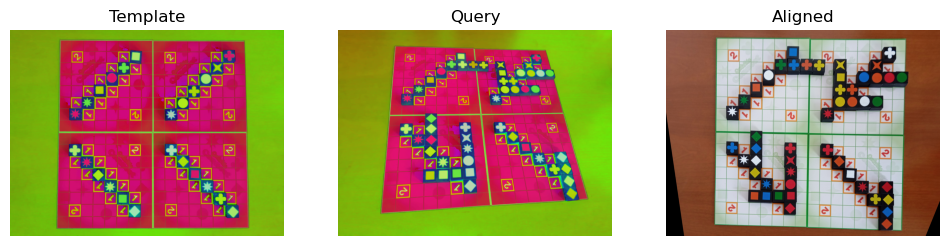

In [11]:
tpl, qry, aligned_img = align_board(template_img, query_img, output_size=(800,800), show_details=False , use_sift=True)

plt.figure(figsize=(12,4))
for i, img in enumerate([tpl, qry, aligned_img], 1):
    plt.subplot(1,3,i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(["Template","Query","Aligned"][i-1])
plt.show()

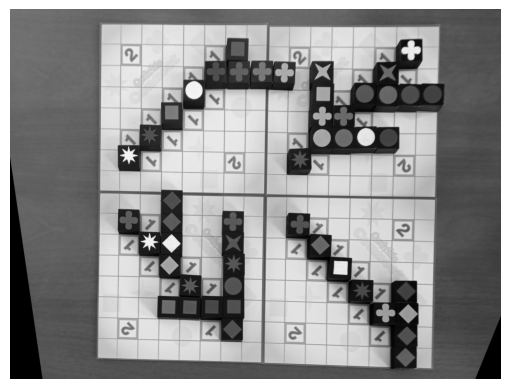

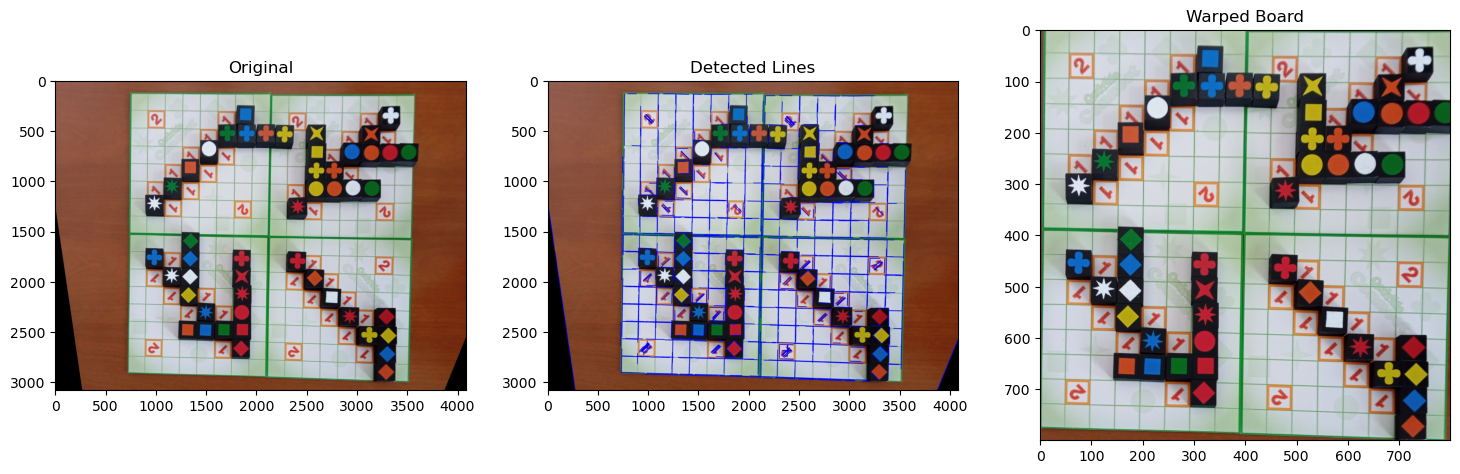

In [24]:
original, lines, warped = detect_board_and_warp(aligned_img)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.title("Detected Lines")
plt.imshow(cv2.cvtColor(lines, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.title("Warped Board")
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

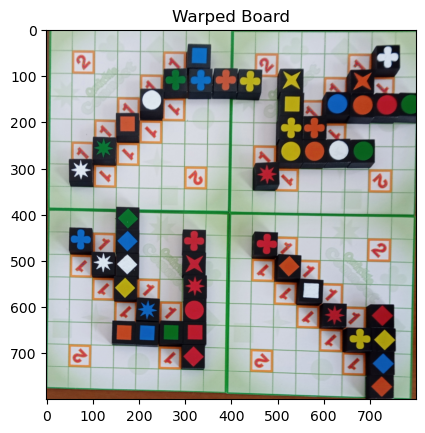

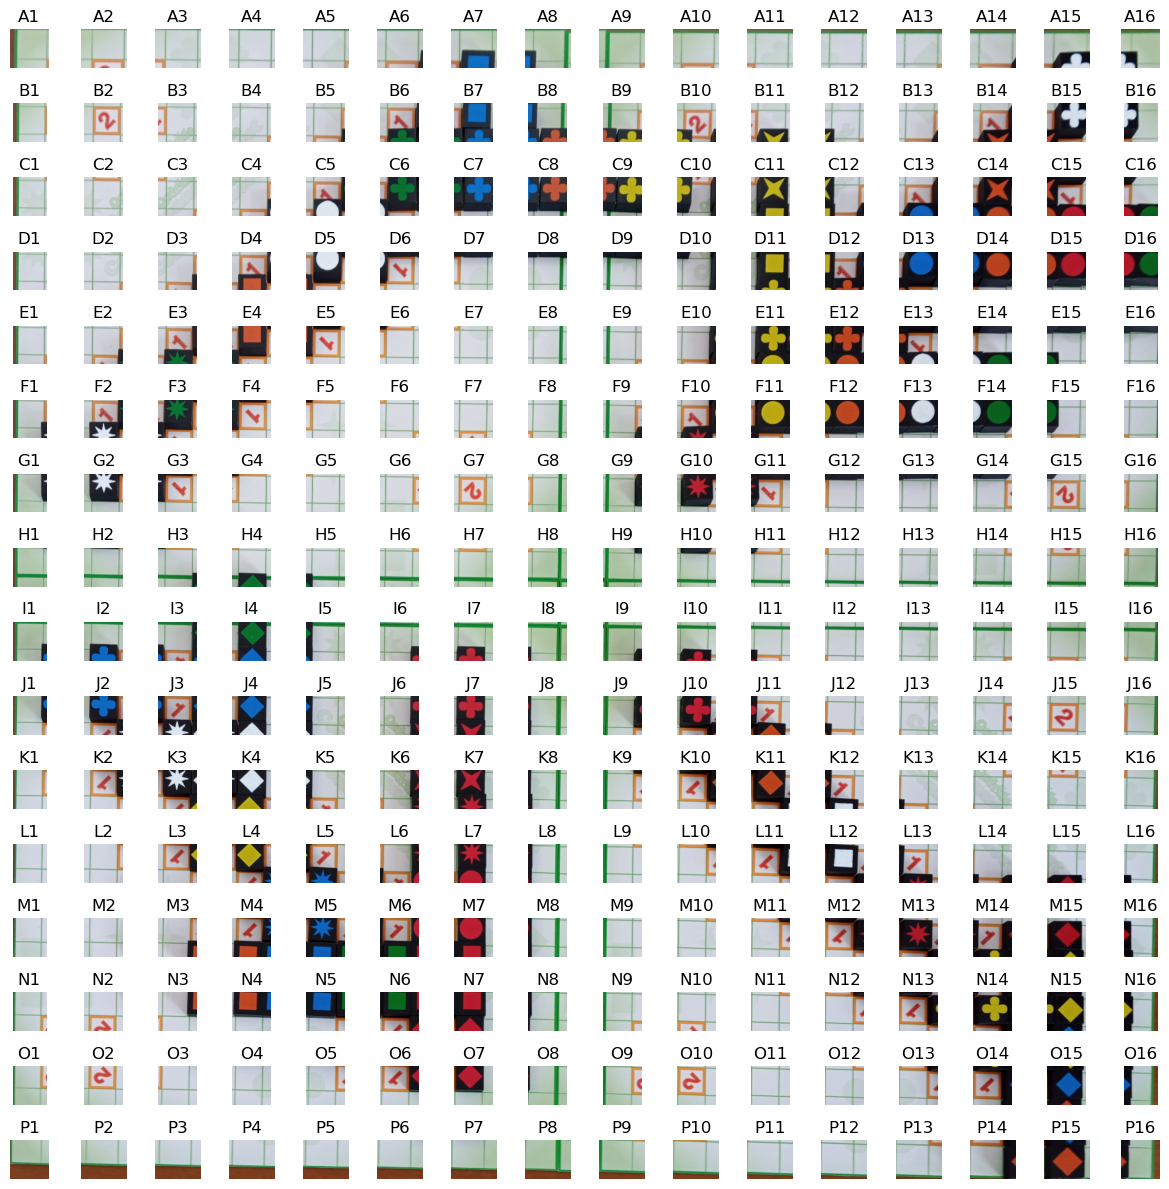

In [34]:
cells_grid = split_board_into_cells(warped, 16, padding=0.2)

plt.title("Warped Board")
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(12, 12))
for i, (label, cell_img) in enumerate(list(cells_grid.items()), 1):
    plt.subplot(16, 16, i)
    plt.imshow(cv2.cvtColor(cell_img, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

